In [1]:
import random

# Set the global seed
_GLOBAL_SEED = 42
random.seed(_GLOBAL_SEED)

In [2]:
import pandas as pd

# Read the training dataset
train_df = pd.read_csv('../_Dataset/train_dataset.csv')

# Read the test dataset
test_df = pd.read_csv('../_Dataset/test_dataset.csv')


In [3]:
train_genetic_disorder_df = train_df.drop("disorder_subclass", axis=1)
test_genetic_disorder_df = test_df.drop("disorder_subclass", axis=1)

Format the dataset

In [4]:
train_genetic_disorder_x = train_genetic_disorder_df.drop("genetic_disorder",axis=1)
train_genetic_disorder_y = train_genetic_disorder_df["genetic_disorder"]

test_genetic_disorder_x = test_genetic_disorder_df.drop("genetic_disorder",axis=1)
test_genetic_disorder_y = test_genetic_disorder_df["genetic_disorder"]

Normalize the dataset

In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the training data
train_genetic_disorder_x = scaler.fit_transform(train_genetic_disorder_x)

# Use the same scaler to transform the test data
test_genetic_disorder_x = scaler.transform(test_genetic_disorder_x)

Declare the models

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

logistic_regression_classifier = LogisticRegression(solver='newton-cg', random_state=_GLOBAL_SEED)
kn_classifier = KNeighborsClassifier()
decision_tree_classifier = DecisionTreeClassifier(random_state=_GLOBAL_SEED)
gaussian_nb_classifier = GaussianNB()
random_forest_classifier = RandomForestClassifier(random_state=_GLOBAL_SEED)
gradient_boosting_classifier = GradientBoostingClassifier(random_state=_GLOBAL_SEED)
xgb_classifier = XGBClassifier(random_state=_GLOBAL_SEED)
lgb_classifier = LGBMClassifier(random_state=_GLOBAL_SEED)
svc_classifier = SVC(decision_function_shape='ovo')
catb_classifier = CatBoostClassifier(random_state=_GLOBAL_SEED, verbose=False)

# Assuming catb_classifier is your CatBoostClassifier
catb_classifier = CalibratedClassifierCV(catb_classifier, method='sigmoid', cv=5)

Train the models on the genetic disorder training dataset

In [7]:
logistic_regression_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
kn_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
decision_tree_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
gaussian_nb_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
random_forest_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
gradient_boosting_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
xgb_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
lgb_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
svc_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)
catb_classifier.fit(train_genetic_disorder_x, train_genetic_disorder_y)

models_collection = {
    'Logistic Regression': logistic_regression_classifier, 
    'K-Nearest Neighbors': kn_classifier, 
    'Decision Tree': decision_tree_classifier, 
    'Gaussian Naive Bayes': gaussian_nb_classifier, 
    'Random Forest': random_forest_classifier, 
    'Gradient Boosting': gradient_boosting_classifier, 
    'XGBoost': xgb_classifier, 
    'LightGBM': lgb_classifier,
    'Support Vector Classifier': svc_classifier,
    'CatBoost': catb_classifier
}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 14437, number of used features: 29
[LightGBM] [Info] Start training from score -0.674550
[LightGBM] [Info] Start training from score -2.248456
[LightGBM] [Info] Start training from score -0.954376


In [8]:
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error

# Initialize an empty dictionary to store the results
results = {}

for model_name, model in models_collection.items():
    # Make predictions on the test data
    predictions = model.predict(test_genetic_disorder_x)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_genetic_disorder_y, predictions)
    
    # Calculate recall
    recall = recall_score(test_genetic_disorder_y, predictions, average='weighted')
    
    # Calculate mean squared error
    mse = mean_squared_error(test_genetic_disorder_y, predictions)
    
    # Store the results
    results[model_name] = {'Accuracy': accuracy, 'Recall': recall, 'Mean Squared Error': mse}
    
# Sort the results by accuracy
sorted_results = sorted(results.items(), key=lambda item: item[1]['Accuracy'], reverse=True)


In [9]:
# Print the sorted results
for model_name, metrics in sorted_results:
    print("---------------------------")
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("---------------------------")

---------------------------
Model: CatBoost
Accuracy: 0.779224376731302
Recall: 0.779224376731302
Mean Squared Error: 0.6952908587257618
---------------------------
---------------------------
Model: LightGBM
Accuracy: 0.7714681440443213
Recall: 0.7714681440443213
Mean Squared Error: 0.7263157894736842
---------------------------
---------------------------
Model: XGBoost
Accuracy: 0.7614958448753463
Recall: 0.7614958448753463
Mean Squared Error: 0.7595567867036012
---------------------------
---------------------------
Model: Gradient Boosting
Accuracy: 0.7576177285318559
Recall: 0.7576177285318559
Mean Squared Error: 0.788365650969529
---------------------------
---------------------------
Model: Random Forest
Accuracy: 0.7193905817174515
Recall: 0.7193905817174515
Mean Squared Error: 0.9047091412742382
---------------------------
---------------------------
Model: Decision Tree
Accuracy: 0.6836565096952909
Recall: 0.6836565096952909
Mean Squared Error: 0.9778393351800554
-----------

Use the top 4 models to create an ensemle model

In [10]:
from sklearn.ensemble import VotingClassifier

# Get the top 4 models
top_4_models = sorted_results[:4]

# Create a list of tuples where each tuple contains a model name and an estimator
estimators = [(model_name, models_collection[model_name]) for model_name, _ in top_4_models]

# Create the ensemble model
ensemble = VotingClassifier(estimators=estimators, voting='soft')

# Train the ensemble model
ensemble.fit(train_genetic_disorder_x, train_genetic_disorder_y)

# Make predictions on the test data
ensemble_predictions = ensemble.predict(test_genetic_disorder_x)

# Calculate and print the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(test_genetic_disorder_y, ensemble_predictions)

# Calculate recall
ensemble_recall = recall_score(test_genetic_disorder_y, ensemble_predictions, average='weighted')

# Calculate mean squared error
ensemble_mse = mean_squared_error(test_genetic_disorder_y, ensemble_predictions)

print(f"Ensemble accuracy: {ensemble_accuracy}")
print(f"Ensemble recall: {ensemble_recall}")
print(f"Ensemble mean squared error: {ensemble_mse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 14437, number of used features: 29
[LightGBM] [Info] Start training from score -0.674550
[LightGBM] [Info] Start training from score -2.248456
[LightGBM] [Info] Start training from score -0.954376
Ensemble accuracy: 0.7797783933518005
Ensemble recall: 0.7797783933518005
Ensemble mean squared error: 0.6997229916897507


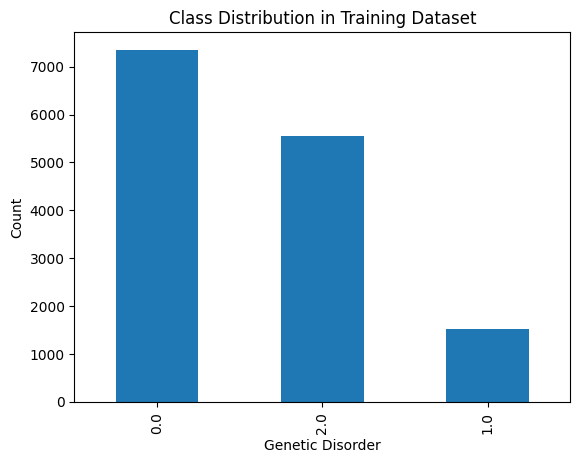

In [12]:
import numpy as np
import matplotlib.pyplot as plt

train_genetic_disorder_y.value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Genetic Disorder')
plt.ylabel('Count')
plt.show()

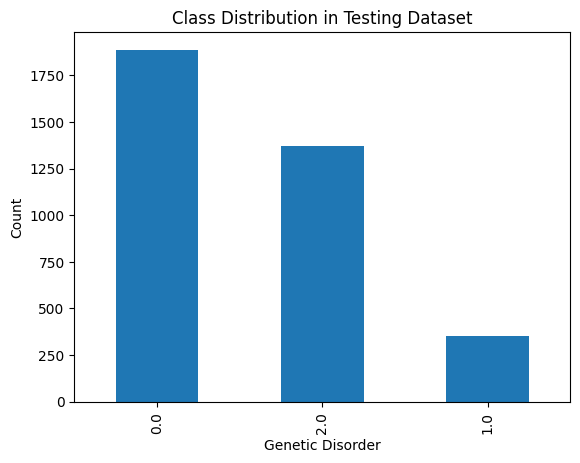

In [15]:
import numpy as np
import matplotlib.pyplot as plt

test_genetic_disorder_y.value_counts().plot(kind='bar')
plt.title('Class Distribution in Testing Dataset')
plt.xlabel('Genetic Disorder')
plt.ylabel('Count')
plt.show()

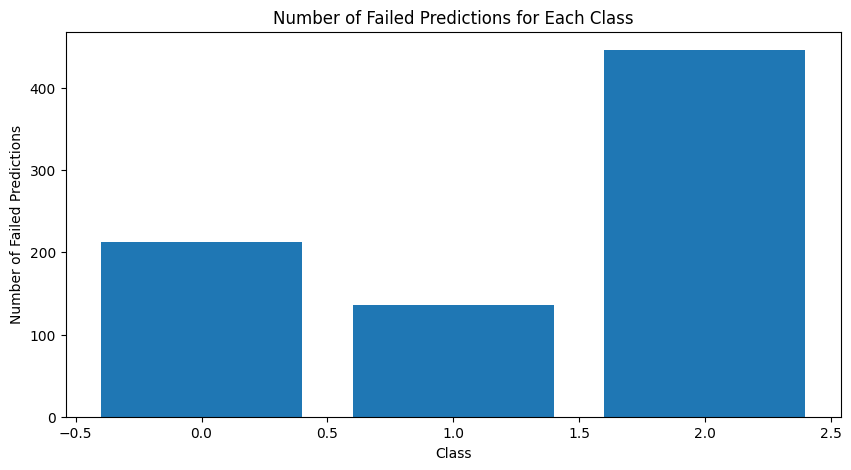

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the number of failed predictions for each class
failed_predictions = np.where(test_genetic_disorder_y != ensemble_predictions, 1, 0)
failed_predictions_per_class = np.bincount(test_genetic_disorder_y[failed_predictions == 1])

# Plot the number of failed predictions for each class
plt.figure(figsize=(10, 5))
plt.bar(range(len(failed_predictions_per_class)), failed_predictions_per_class)
plt.title('Number of Failed Predictions for Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Failed Predictions')
plt.show()